# Introduction #

In the last lesson we saw that a convnet performs feature extraction through a sequence of three operations -- filter, detect, condense. In this lesson, we'll describe these operations in terms of **activations** and **weights** as you learned about in *Introduction to Deep Learning*. This will also be an introduction to **convolution**, **ReLU**, and **pooling**, which we will continue in Lesson 4.

# Filter #

Recall that a **convolutional layer** will typically carry out the filtering step. The **weights** a network learns during training are primarily contained in its convolutional layers. We can represent them as small arrays called **kernels**

<!--TODO: a kernel-->

A convolutional layer will usually contain many kernels. They are what determine the kind of filtering that occurs.

The pattern of numbers in the array defines the effect of a kernel. You can think about a kernel as a kind of polarized lens, letting through only a certain pattern of information. The kernel above will filter for vertical lines.

The **activations** in the network we call **feature maps**. They are what result when we apply a filter to an image; they are the visual features the network extracts.

The first feature maps are the color channels of the image. A grayscale image has one channel.

<!--TODO: grayscale channel-->

A color image will have three channels: red, green, and blue.

<img src="./images/3-channels-rgb.png" width="600" alt="The channels of a color image.">

As more extraction operations are applied, the feature maps become increasingly refined.

<!--TODO: feature maps simple to complex-->

Here are some examples of kernels applied to feature maps:

<!--TODO: kernels applied to feature maps-->

## Features: The Depth Dimension ##

*(This section makes some terminology we'll be using a bit more precise. It's not essential to anything that follows, so feel free to skip it if you want. The important thing is just to understand that a convolutional layer contains many kernels.)*

When an image first enters a network, it exists as a set of channels. We usually think about the channels as being the *depth* dimension, with the width and height as the two spatial dimensions. In the language of TensorFlow, an image is a tensor with shape `[height, width, channels]`.

<img src="./images/3-channels-stack.png" width="300" alt="Channels form the depth dimension.">

A convolutional layer will apply a kernel to each channel in the input, and the collection of these kernels is what we call a **filter**. One filter produces one feature map.

<!--TODO: filter to feature map-->

A convolutional layer may produce many feature maps. So, if a convolutional layer producing 16 feature maps is applied to an image with 3 channels, it will contain 16*3=48 kernels.

As mentioned, the channels are the first set of feature maps. More generally then, then depth dimension of the activation tensors contains the feature maps: `[height, width, features]`.

# Detect #

After filtering, the feature maps pass through the activation function. The **ReLU activation** has a graph like this:

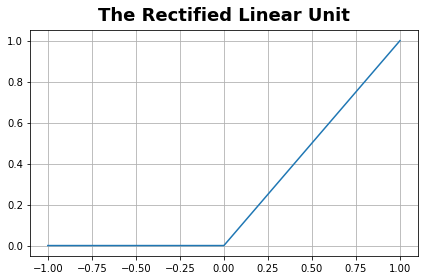

In [1]:
#$HIDE$
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow.keras.backend as K

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')


x = np.linspace(-1.0, 1.0, 1000)
y = K.relu(x)

plt.title("The Rectified Linear Unit")
plt.plot(x, y)
plt.grid()
plt.show();

(*ReLU* stands for *Rectified Linear Unit*.)

You could think about the activation function as normalizing the pixel values according to some measure of importance. The ReLU function says that negative values are not important and so sets them to 0. ("Everything unimportant is equally unimportant.")

Like other activation functions used in neural networks, the ReLU function is *nonlinear*. Essentially this means that the total effect of all the layers in the network is different than what we would get by just adding the effects together, becoming, in effect, a network with one layer only.

The ReLU function ensures that only pixels with positive activation remain in the feature map. This is desireable because we don't want any negative activations destroying the features we detect deeper in the network, which is what would happen if we simply added them together.

Here is ReLU applied to some feature maps. Notice how it succeeds at isolating the feature of interest.

<!--TODO: ReLU applied to feature maps-->

# Condense #

Notice that after applying the ReLU function the feature map ends up with a lot of "dead space," that is, large areas containing only 0's (the black areas in the image). Carrying these 0 activations through the entire network would unnecessarily increase the number of parameters. Instead, we would like to **condense** the feature map to retain only the information of interest -- the feature itself.

This is what the pooling operation known as **maximum pooling** does. Max pooling will take a block of activations in the original feature map and replace them with the maximum activation in that block.

<!--TODO: max pooling-->

You can see that pooling reduces the dimensions of the image. In this sense, pooling is a kind of downsampling applied to the feature map.

Altogether, the extraction operation looks like this:

<!--TODO: extraction start to finish-->

# Example - Apply Operations #

Let's apply these operations to an image to get a feel for what they do.

Here is the image we'll use for this example:

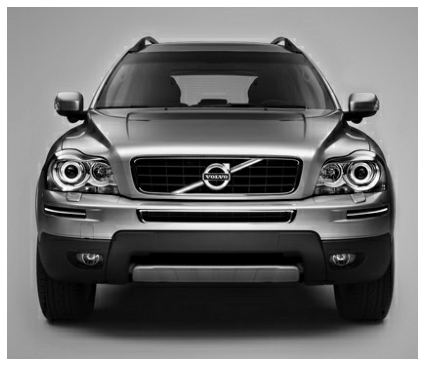

In [2]:
import tensorflow as tf

img_path = './images/car_feature.jpg'
img = tf.io.read_file(img_path)
img = tf.io.decode_jpeg(img)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(img), cmap='gray')
plt.axis('off')
plt.show();

We'll start by creating a simple model that performs the feature extraction. Then we'll pull out the layers so that we can apply them one by one.

In [3]:
from tensorflow.keras import Sequential
import tensorflow.keras.layers as layers

# Create Layers
model = Sequential([
    layers.Conv2D(filters=1,
                  kernel_size=3,
                  padding='same',
                  use_bias=False,
                  input_shape=img.shape),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=2,
                     padding='same'),
])

conv2d, relu, maxpool2d = model.layers

Notice that this is essentially the convolutional block you learned about in Lesson 2.

Now for the filtering step, we'll define a kernel and then apply it with the convolution. The kernel in this case is an "edge detection" kernel.

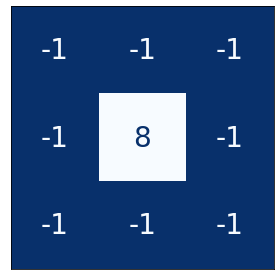

In [4]:
import visiontools

krn = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

visiontools.show_kernel(krn)

Remember that a kernel is a set of weights for a convolutional layer. We'll give the `conv2d` layer we've created these weights with its `set_weights` method.

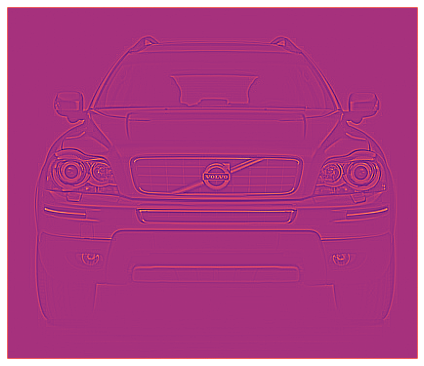

In [5]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(img, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(krn, [*krn.shape, 1, 1])

# Apply the kernel to the layer. Since a conv layer can have many
# kernels, we pass it in a list.
conv2d.set_weights([kernel])

# You can call the layer on the image just like a function.
image_filter = conv2d(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

Next is the detection step with the ReLU function.

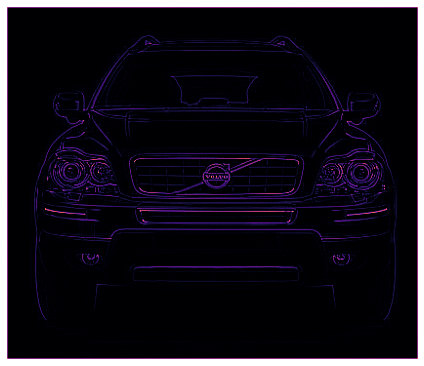

In [6]:
image_detect = relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

The `relu` and `maxpool2d` layers have no trainable weights, so we can simply pass in the image.

And last is condensing with maximum pooling.

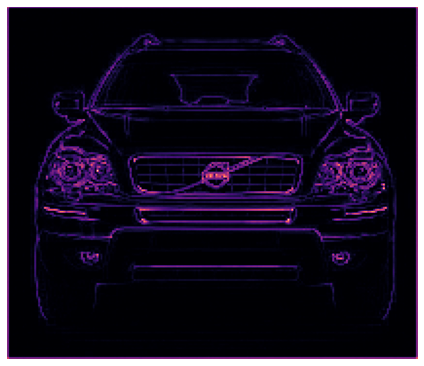

In [7]:
image_condense = maxpool2d(image_detect)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.show();

Let's look at the whole process start-to-finish.

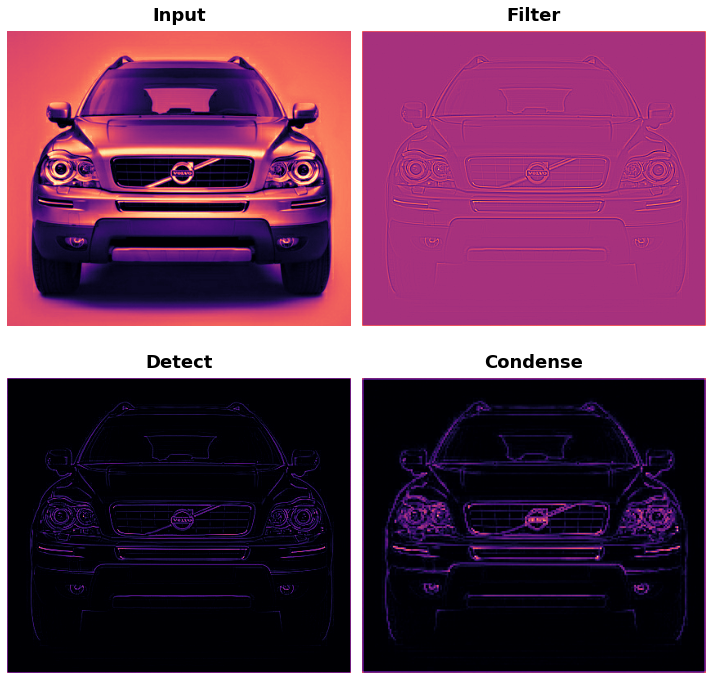

In [8]:
visiontools.show_extraction(img, krn)

# Example - Visualize Activations #

It can be instructive to look at the activations an image produces in a network throughout its layers. We've included a function the `visiontools` module that will plot them for you. Let's look at some activations in the network from Lesson 2 (using the same image as before).

In [9]:
visiontools.show_activations(img, model=convolutional_classifier)

AttributeError: module 'visiontools' has no attribute 'show_activations'

You can see how the features extracted become more and more refined as the activations flow deeper into the network.

# Conclusion #